# DTSA 5511 Final Project

## Detecting Cargo Ships in Satellite Imagery 



## Background 

Satellite imagery provides unique insights into various markets, including agriculture, defense and intelligence, energy, and finance. New commercial imagery providers, such as Planet, are using constellations of small satellites to capture images of the entire Earth every day.

This flood of new imagery is outgrowing the ability for organizations to manually look at each image that gets captured, and there is a need for machine learning and computer vision algorithms to help automate the analysis process. Although the aim of this dataset is to help address the difficult task of detecting the location of large ships in satellite images, automating this process can be applied to many issues including monitoring port activity levels and supply chain analysis.


The NYT has used cargo ship detection to track what are known as "ghost ships". These ships turn off their AIS tracker, essentially going "dark", and offloading cargo to nations like North Korea or countries with sanctions like Iran or Russia. I was first interested in this project many years ago when I read a NYT article about how they tracked a mercedes purchased in Germany all the way to North Korea. 

You can read the articles that influenced me to make this project below: 

https://www.nytimes.com/2019/07/16/world/asia/north-korea-luxury-goods-sanctions.html

https://www.nytimes.com/2019/07/02/world/middleeast/china-oil-iran-sanctions.html

https://www.nytimes.com/interactive/2023/05/30/world/asia/russia-oil-ships-sanctions.html


### Objective 

The objective of this final project is to create a (???????? )neural network algorithm that can detect cargo ships in satellite images of the San Francisco Bay Area. I will also be using this model to detect cargo ships in the 8 full scene images. 



### Data

Satellite imagery provides unique insights into various markets, including agriculture, defense and intelligence, energy, and finance. New commercial imagery providers, such as Planet, are using constellations of small satellites to capture images of the entire Earth every day.

This flood of new imagery is outgrowing the ability for organizations to manually look at each image that gets captured, and there is a need for machine learning and computer vision algorithms to help automate the analysis process.

The aim of this dataset is to help address the difficult task of detecting the location of large ships in satellite images. Automating this process can be applied to many issues including monitoring port activity levels and supply chain analysis.

#### Content
The dataset consists of images extracted from Planet satellite imagery collected over the San Francisco Bay and San Pedro Bay areas of California. It includes 4000 80x80 RGB images labeled with either a "ship" or "no-ship" classification. Images were derived from PlanetScope full-frame visual scene products, which are orthorectified to a 3-meter pixel size.

Provided is a zipped directory shipsnet.zip that contains the entire dataset as .png images. 
Each individual image filename follows a specific format: {label} _ {scene id} _ {longitude} _ {latitude}.png

* label: Valued 1 or 0, representing the "ship" class and "no-ship" class, respectively.
* scene id: The unique identifier of the PlanetScope visual scene the image was extracted from. The scene id can be used with the Planet API to discover and download the entire scene.
* longitude_latitude: The longitude and latitude coordinates of the image center point, with values separated by a single underscore.
* The dataset is also distributed as a JSON formatted text file shipsnet.json. The loaded object contains data, label, scene_ids, and location lists.

The pixel value data for each 80x80 RGB image is stored as a list of 19200 integers within the data list. The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue. The image is stored in row-major order so that the first 80 entries of the array are the red channel values of the first row of the image.

The list values at index i in labels, scene_ids, and locations each correspond to the i-th image in the data list.

#### Class Labels
The "ship" class includes 1000 images. Images in this class are centered on the body of a single ship. Ships of different sizes, orientations, and atmospheric collection conditions are included. Example images from this class are shown below.


The "no-ship" class includes 3000 images. A third of these are a random sampling of different land cover features - water, vegetation, bare earth, buildings, etc. - that do not include any portion of a ship. The next third are "partial ships" that contain only a portion of a ship, but not enough to meet the full definition of the "ship" class. The last third are images that have previously been mislabeled by machine learning models, typically caused by bright pixels or strong linear features. 


#### Scenes
Eight full-scene images are included in the scenes directory. Scenes can be used to visualize the performance of classification models trained on the dataset. Verify a model's accuracy by applying it across a scene and viewing where 'ship' classifications occur - the context provided by the scene helps determine positive hits from false alarms. 


Data can be found here: 

https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery/data

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import json,sys,random,itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from itertools import *
from xgboost import XGBClassifier
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras import regularizers
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
data = pd.read_json('shipsnet.json')

In [4]:
data.head()

data  labels  \
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   

                                   locations             scene_ids  
0    [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1    [-122.33222866289329, 37.7491755586813]  20170705_180816_103e  
2  [-118.14283073363218, 33.736016066914175]  20180712_211331_0f06  
3   [-122.34784341495181, 37.76648707436548]  20170609_180756_103a  
4   [-122.34852408322172, 37.75878462398653]  20170515_180653_1007

## Exploratory Data Analysis 

In [5]:
data.labels.value_counts()

0    3000
1    1000
Name: labels, dtype: int64

Double checking to see that we have 3000 images without a ship and 1000 images with a ship. 

In [6]:
#making ship only dataset for visualizing later 

ship = data[:1000]
ship.head()

data  labels  \
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   

                                   locations             scene_ids  
0    [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1    [-122.33222866289329, 37.7491755586813]  20170705_180816_103e  
2  [-118.14283073363218, 33.736016066914175]  20180712_211331_0f06  
3   [-122.34784341495181, 37.76648707436548]  20170609_180756_103a  
4   [-122.34852408322172, 37.75878462398653]  20170515_180653_1007

In [7]:
#making no ship only dataset for visualizing later 
noship = data[1000:4000]
noship.head()

data  labels  \
1000  [73, 75, 75, 73, 75, 75, 76, 77, 78, 78, 80, 8...       0   
1001  [165, 171, 163, 152, 142, 133, 132, 133, 130, ...       0   
1002  [198, 202, 210, 214, 217, 221, 223, 222, 223, ...       0   
1003  [155, 170, 175, 181, 172, 150, 124, 125, 129, ...       0   
1004  [74, 80, 80, 81, 81, 81, 82, 81, 83, 84, 80, 8...       0   

                                     locations             scene_ids  
1000  [-122.33459961419122, 37.81140628875495]  20161218_180844_0e26  
1001  [-122.13440135290679, 37.74732085488439]  20170505_181257_0e2f  
1002  [-122.1377855013356, 37.708030696820344]  20170505_181258_0e2f  
1003  [-122.09571903813976, 37.64920246656525]  20170905_181215_0f12  
1004  [-122.38792956593555, 37.82067246616187]  20170917_190616_0f3c

In [8]:
img_rows=80
img_cols=80
img_channels=3

In [9]:
x=[]
for image in data['data']:
    image=np.array(image)
    image=image.reshape((3, 6400)).T.reshape((80,80,3))
    x.append(image)
x=np.array(x)
y=np.array(data['labels'])

In [10]:
image_shape=(80,80,3)

In [11]:
print(x.shape)
print(y.shape)

(4000, 80, 80, 3)
(4000,)


Lets take a look at some sample pictures 

In [12]:
#This code changes the sample pictures do not run again

#from random import sample
#plot_num_images=6
#num_imgs=x.shape[0]
#indices=sample(range(0,num_imgs+1),plot_num_images)
indices = [2110, 2476, 958, 3810, 215, 82]

indices

[2110, 2476, 958, 3810, 215, 82]

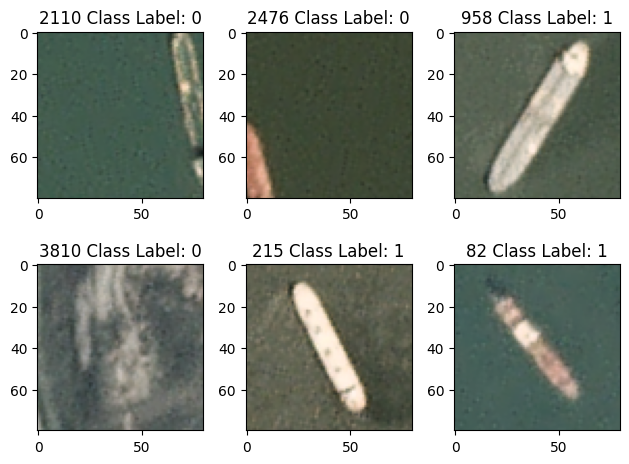

In [13]:
i=0
for index in indices:
    plt.subplot(2,3,i+1)
    img=x[index]
    plt.imshow(img)
    class_label=y[index]
    plt.title(str(index) + ' ' + 'Class Label: {}'.format(class_label) )
    i+=1
plt.tight_layout()
plt.show()

### RBG Pixel distribution of Ship and No Ship Images

The images above tell us that there are ways a model can distinguish between ships and no ships. Looking at the Pixel distribution will give us an idea of how it can be done

In [14]:
### Ship Image Distributions

image1 = noship['data'][2110]

image2 = noship['data'][2476]

image3 = noship['data'][3810]

image4 = ship['data'][958]

image5 = ship['data'][215]

image6 = ship['data'][82]

Remember that the pixel value data for each 80x80 RGB image is stored as a list of 19200 integers within the data list. The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue. The image is stored in row-major order so that the first 80 entries of the array are the red channel values of the first row of the image.

### No Ship Images

Text(0.5, 1.0, 'Pixel Distribution of Image 2110 (No Ship)')

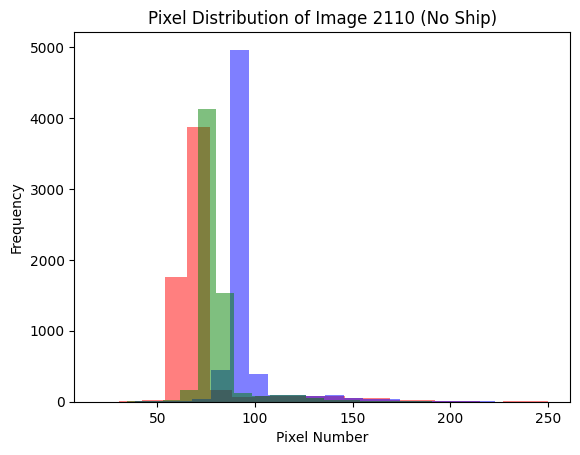

In [15]:
R_s1 = image1[0:6400] #red
B_s1 = image1[6400:12800] #blue
G_s1 = image1[12800:19200] #green
plt.hist(R_s1,color = 'r',bins = 20,alpha = 0.5)
plt.hist(B_s1,color = 'b',bins = 20,alpha = 0.5)
plt.hist(G_s1,color = 'g',bins = 20,alpha =0.5)
plt.xlabel('Pixel Number')
plt.ylabel('Frequency')
plt.title('Pixel Distribution of Image 2110 (No Ship)')

Image 2110 is a no ship image. However, it can be confusing for our model because of a partial ship like object or barge in it. We will compare ship images to this later on to see if the pixel frequency and distribution match

Text(0.5, 1.0, 'Pixel Distribution of Image 2476 (No Ship)')

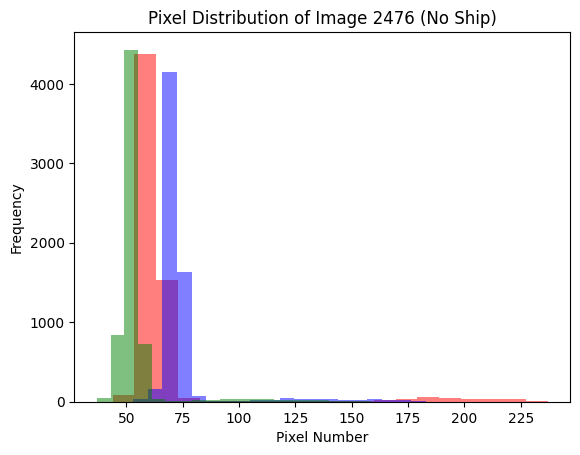

In [16]:
R_s2 = image2[0:6400] #red
B_s2 = image2[6400:12800] #blue
G_s2 = image2[12800:19200] #green
plt.hist(R_s2,color = 'r',bins = 20,alpha = 0.5)
plt.hist(B_s2,color = 'b',bins = 20,alpha = 0.5)
plt.hist(G_s2,color = 'g',bins = 20,alpha =0.5)
plt.xlabel('Pixel Number')
plt.ylabel('Frequency')
plt.title('Pixel Distribution of Image 2476 (No Ship)')

Image 2476 is another no ship image. This image also has a partial ship like object in it and yet we see a shift in pixel distribution to image 2110. Most likely due to the color of the object and sea. 

Text(0.5, 1.0, 'Pixel Distribution of Image 3810 (No Ship)')

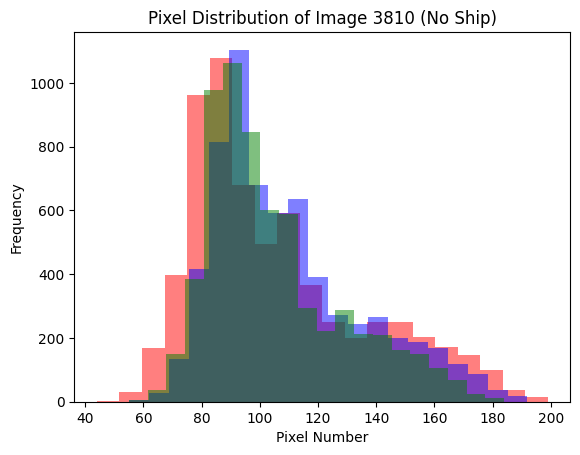

In [17]:
R_s3 = image3[0:6400] #red
B_s3 = image3[6400:12800] #blue
G_s3 = image3[12800:19200] #green
plt.hist(R_s3,color = 'r',bins = 20,alpha = 0.5)
plt.hist(B_s3,color = 'b',bins = 20,alpha = 0.5)
plt.hist(G_s3,color = 'g',bins = 20,alpha =0.5)
plt.xlabel('Pixel Number')
plt.ylabel('Frequency')
plt.title('Pixel Distribution of Image 3810 (No Ship)')

Image 3810 is very important. This image is definitely land and very very different from the two images below that might confuse our model. Im confident these images of land or mix land/ocean images wont confuse our model due to this distribution. 

### Ship Images 

Text(0.5, 1.0, 'Pixel Distribution of Image 958 (No Ship)')

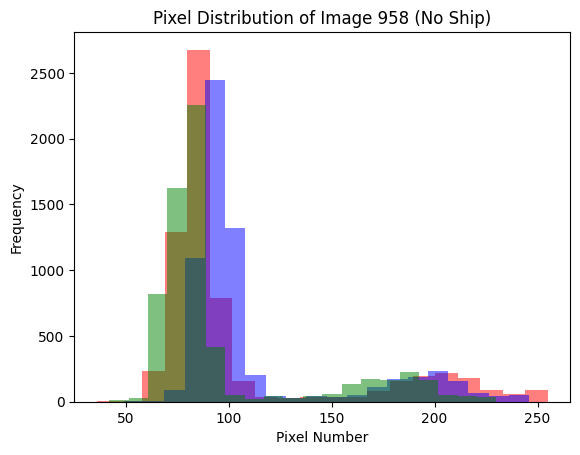

In [18]:
R_s4 = image4[0:6400] #red
B_s4 = image4[6400:12800] #blue
G_s4 = image4[12800:19200] #green
plt.hist(R_s4,color = 'r',bins = 20,alpha = 0.5)
plt.hist(B_s4,color = 'b',bins = 20,alpha = 0.5)
plt.hist(G_s4,color = 'g',bins = 20,alpha =0.5)
plt.xlabel('Pixel Number')
plt.ylabel('Frequency')
plt.title('Pixel Distribution of Image 958 (No Ship)')

The first ship image we look at shows a similar tower shape of Red/Green/Blue values but we also see a small hump in the high valued pixel numbers. This was not something we saw in the no ship images that we looked at so far

Text(0.5, 1.0, 'Pixel Distribution of Image 215 (Ship)')

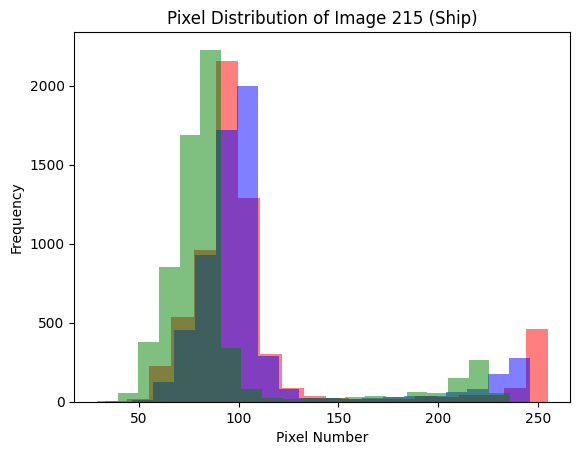

In [19]:
R_s5 = image5[0:6400] #red
B_s5 = image5[6400:12800] #blue
G_s5 = image5[12800:19200] #green
plt.hist(R_s5,color = 'r',bins = 20,alpha = 0.5)
plt.hist(B_s5,color = 'b',bins = 20,alpha = 0.5)
plt.hist(G_s5,color = 'g',bins = 20,alpha =0.5)
plt.xlabel('Pixel Number')
plt.ylabel('Frequency')
plt.title('Pixel Distribution of Image 215 (Ship)')

Image 215 shows us something interesting. The Green values in low value pixel numbers are more spread out, most likley due to sea water color. But we also see more of a higher bump in higher value pixel numbers.

Text(0.5, 1.0, 'Pixel Distribution of Image 82 (Ship)')

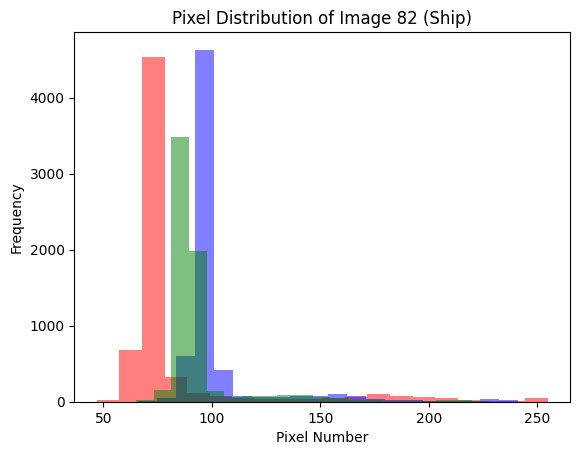

In [20]:
R_s6 = image6[0:6400] #red
B_s6 = image6[6400:12800] #blue
G_s6 = image6[12800:19200] #green
plt.hist(R_s6,color = 'r',bins = 20,alpha = 0.5)
plt.hist(B_s6,color = 'b',bins = 20,alpha = 0.5)
plt.hist(G_s6,color = 'g',bins = 20,alpha =0.5)
plt.xlabel('Pixel Number')
plt.ylabel('Frequency')
plt.title('Pixel Distribution of Image 82 (Ship)')

Image 82 has very thin spikes at low value pixel numbers and our small hump is in the middle of the pixel number value and not so high as before. This is similar to our non ship images so Im curious to see how the model classifies this image but the space between red,green and blue spikes in the low value pixel number might help. 

## Model Setup

In [21]:
#loading data again for creating train/test set
#there is probably an easier way to convert pandas df to a np array with astype uint8 
#but i was having trouble with it

f = open(r'shipsnet.json')
dataset = json.load(f)
f.close()

input_data = np.array(dataset['data']).astype('uint8')
labels_data = np.array(dataset['labels']).astype('uint8')

In [22]:
input_data[2]

array([125, 127, 129, ..., 111, 109, 115], dtype=uint8)

In [23]:
n_spectrum = 3 # color chanel (RGB)
weight = 80
height = 80
X = input_data.reshape([-1, n_spectrum, weight, height])
X.shape

(4000, 3, 80, 80)

In [24]:
# Create train set
data_train, data_test, labels_train, labels_test = train_test_split(
    input_data,
    labels_data,
    test_size=.45, random_state=0, stratify=labels_data)

# Create validation and test sets
data_validation, data_test, labels_validation, labels_test = train_test_split(
data_test, labels_test,test_size=.20, random_state=0)

data_train=data_train.reshape(-1, n_spectrum, weight, height)
data_test=data_test.reshape(-1, n_spectrum, weight, height)
data_validation=data_validation.reshape(-1, n_spectrum, weight, height)

print('Train:',data_train.shape, labels_train.shape)
print('Test:', data_test.shape, labels_test.shape)
print('Validation:', data_validation.shape, labels_validation.shape)

Train: (2200, 3, 80, 80) (2200,)
Test: (360, 3, 80, 80) (360,)
Validation: (1440, 3, 80, 80) (1440,)


In [25]:
#permute dimensions of each array

data_t_train=data_train.transpose(0,2,3,1)
data_t_test=data_test.transpose(0,2,3,1)
data_t_validation=data_validation.transpose(0,2,3,1)

Text(0.5, 1.0, 'PCA')

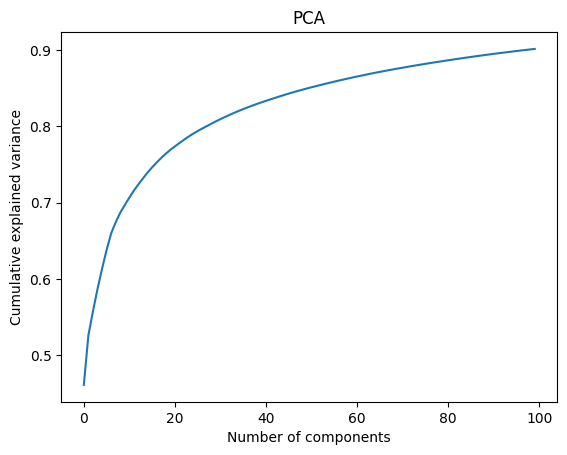

In [26]:
pca = PCA(n_components=100)
values_train=data_train.reshape(-1,(80*80*3))
pca.fit(values_train)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA')

From the plot above it looks like 80 components would be enought to retain most of the dataset information.

In [28]:
NCOMPONENTS = 80

pca = PCA(n_components=NCOMPONENTS)


data_pca_train = pca.fit_transform(data_train.reshape(-1,(80*80*3)))
data_pca_val = pca.transform(data_validation.reshape(-1,(80*80*3)))
data_pca_test = pca.transform(data_test.reshape(-1,(80*80*3)))
pca_std = np.std(data_pca_train)

In [29]:
#Convert the labels vectors from integers to binary class matrices:

labels_train=to_categorical(labels_train)
labels_test=to_categorical(labels_test)
labels_validation=to_categorical(labels_validation)

In [30]:
print(data_pca_val.shape)
print(labels_validation.shape)

(1440, 80)
(1440, 2)


## FCNN model

A Fully Convolutional Neural Network (FCNN) is a type of convolutional neural network (CNN) that uses only convolutional layers and upsampling layers (like transposed convolutions) to process input data and produce output.  Crucially,it does not contain any fully connected (dense) layers.

FCNNs are different from traditional CNNs because they have no fully connected layers, spatial information preservation and upsampling layers. 

No fully connected layers is a defining characteristic. Traditional CNNs often end with one or more fully connected layers that convert the feature maps from the convolutional layers into a fixed-size vector before making a final prediction. FCNNs omit these, instead processing the entire input as a spatial entity. By avoiding fully connected layers, FCNNs maintain spatial information throughout the entire network. This allows them to handle inputs of arbitrary size, and the output is also a spatial map, not just a single vector.FCNNs typically incorporate upsampling layers (often transposed convolutions or deconvolutions) to increase the spatial resolution of the feature maps. 

These characteristic makes FCNNs particularly well-suited for tasks involving spatial reasoning, like object detection. 


In [31]:
model_fcnn = Sequential([
  Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001),input_shape=(80,)),
  Dropout(0.1),
  Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
  Dropout(0.1),
  Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
  Dropout(0.1),
  Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)),
])

model_fcnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,386 (32.76 KB)

 Trainable params: 8,386 (32.76 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model_fcnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

model_fcnn.fit(
  data_pca_train, # training data
  labels_train, # training targets
  validation_data=(data_pca_val, labels_validation),
  epochs=100,
  batch_size=200
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5812 - loss: 116.0388 - val_accuracy: 0.8361 - val_loss: 17.1541
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7566 - loss: 43.4389 - val_accuracy: 0.8611 - val_loss: 12.3673
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7782 - loss: 29.3014 - val_accuracy: 0.8819 - val_loss: 10.1434
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8284 - loss: 21.5380 - val_accuracy: 0.8944 - val_loss: 7.2681
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8508 - loss: 13.3103 - val_accuracy: 0.9021 - val_loss: 6.1277
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8484 - loss: 14.1438 - val_accuracy: 0.9111 - val_loss: 5.1441
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8675 - loss: 9.3248 - val_accuracy: 0.9090 - val_loss: 4.4544
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8800 - loss: 8.3019 - val_accuracy: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9582 - loss: 0.1442 - val_accuracy: 0.9563 - val_loss: 0.5879
Epoch 52/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9585 - loss: 0.1484 - val_accuracy: 0.9590 - val_loss: 0.5781
Epoch 53/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9609 - loss: 0.1319 - val_accuracy: 0.9583 - val_loss: 0.5830
Epoch 54/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9669 - loss: 0.1478 - val_accuracy: 0.9563 - val_loss: 0.5486
Epoch 55/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9725 - loss: 0.1564 - val_accuracy: 0.9569 - val_loss: 0.5343
Epoch 56/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9732 - loss: 0.1282 - val_accuracy: 0.9549 - val_loss: 0.5441
Epoch 57/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9672 - loss: 0.1118 - val_accuracy: 0.9569 - val_loss: 0.5416
Epoch 58/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9692 - loss: 0.1318 - val_accuracy: 0.9528 - val_lo

## Visualize Results 

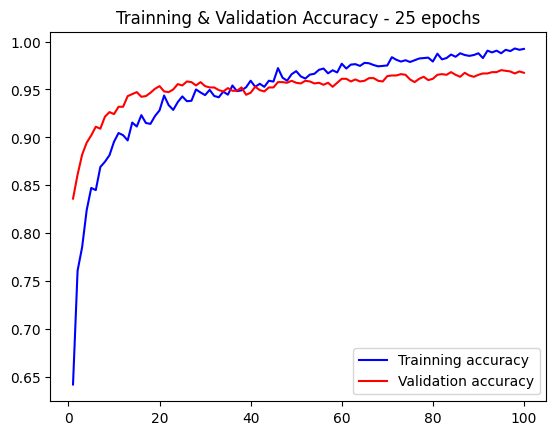

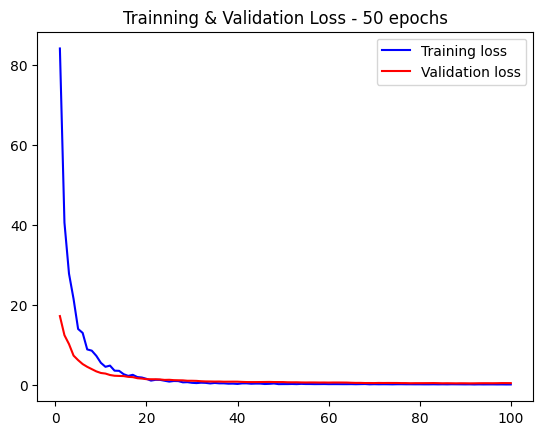

In [33]:
acc=model_fcnn.history.history['accuracy']
val_acc=model_fcnn.history.history['val_accuracy']
loss=model_fcnn.history.history['loss']
val_loss=model_fcnn.history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='Trainning accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Trainning & Validation Accuracy - 25 epochs')
plt.legend()
plt.figure()
plt.plot(epochs,loss, 'b', label='Training loss')
plt.plot(epochs,val_loss, 'r', label='Validation loss')
plt.title('Trainning & Validation Loss - 50 epochs')
plt.legend()
plt.show()

#### Training and Validation Accuracy 

In this plot we see good generalization. Both training and validation accuracy increase steadily, with a small gap between them. We do see a little plateau in the validation accuracy and this could mean overfitting, but it is not significant. 



#### Training and Validation Loss 

In this plot we see very good generalization as both the training loss and validation loss steadily decrease with a small gap between them. 

In [34]:
test_loss, test_acc =model_fcnn.evaluate(
  data_pca_test,
  labels_test
)

print('Test loss', round(test_loss,2))
print('Test accuracy', round(test_acc,2))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9800 - loss: 0.2547 
Test loss 0.29
Test accuracy 0.97


#### Our model has an accuracy of 98 percent!  

Lets now find our Label prediction for the test dataset below

In [35]:
prediction = np.argmax(model_fcnn.predict(data_pca_test), axis=-1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## Confusion Matrix

In [51]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

In [53]:
class_names = ["no-ship","ship"]

<Figure size 640x480 with 0 Axes>

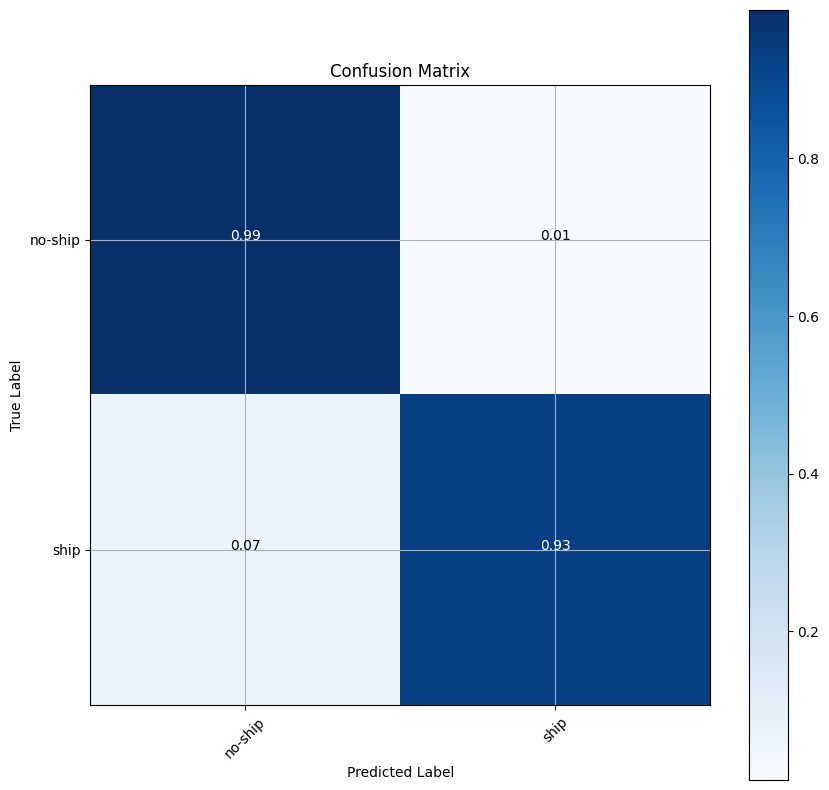

In [56]:
# Evaluate the model on the testing dataset
#test_pred = model_fcnn.predict(labels_test)
#test_pred = np.argmax(test_pred, axis=1)
test_actual = np.argmax(labels_test, axis=1)

# Compute and display the confusion matrix for the testing dataset
cnf_mat_test = confusion_matrix(prediction, test_actual)
plt.figure()
plot_confusion_matrix(cnf_mat_test, classes=class_names)
plt.grid(None)
plt.show()

As we can see from our confusion matrix the model did really well in predicting no ship images like I had predicted. It did a good job of predicting ship images but struggled with false negatives. 

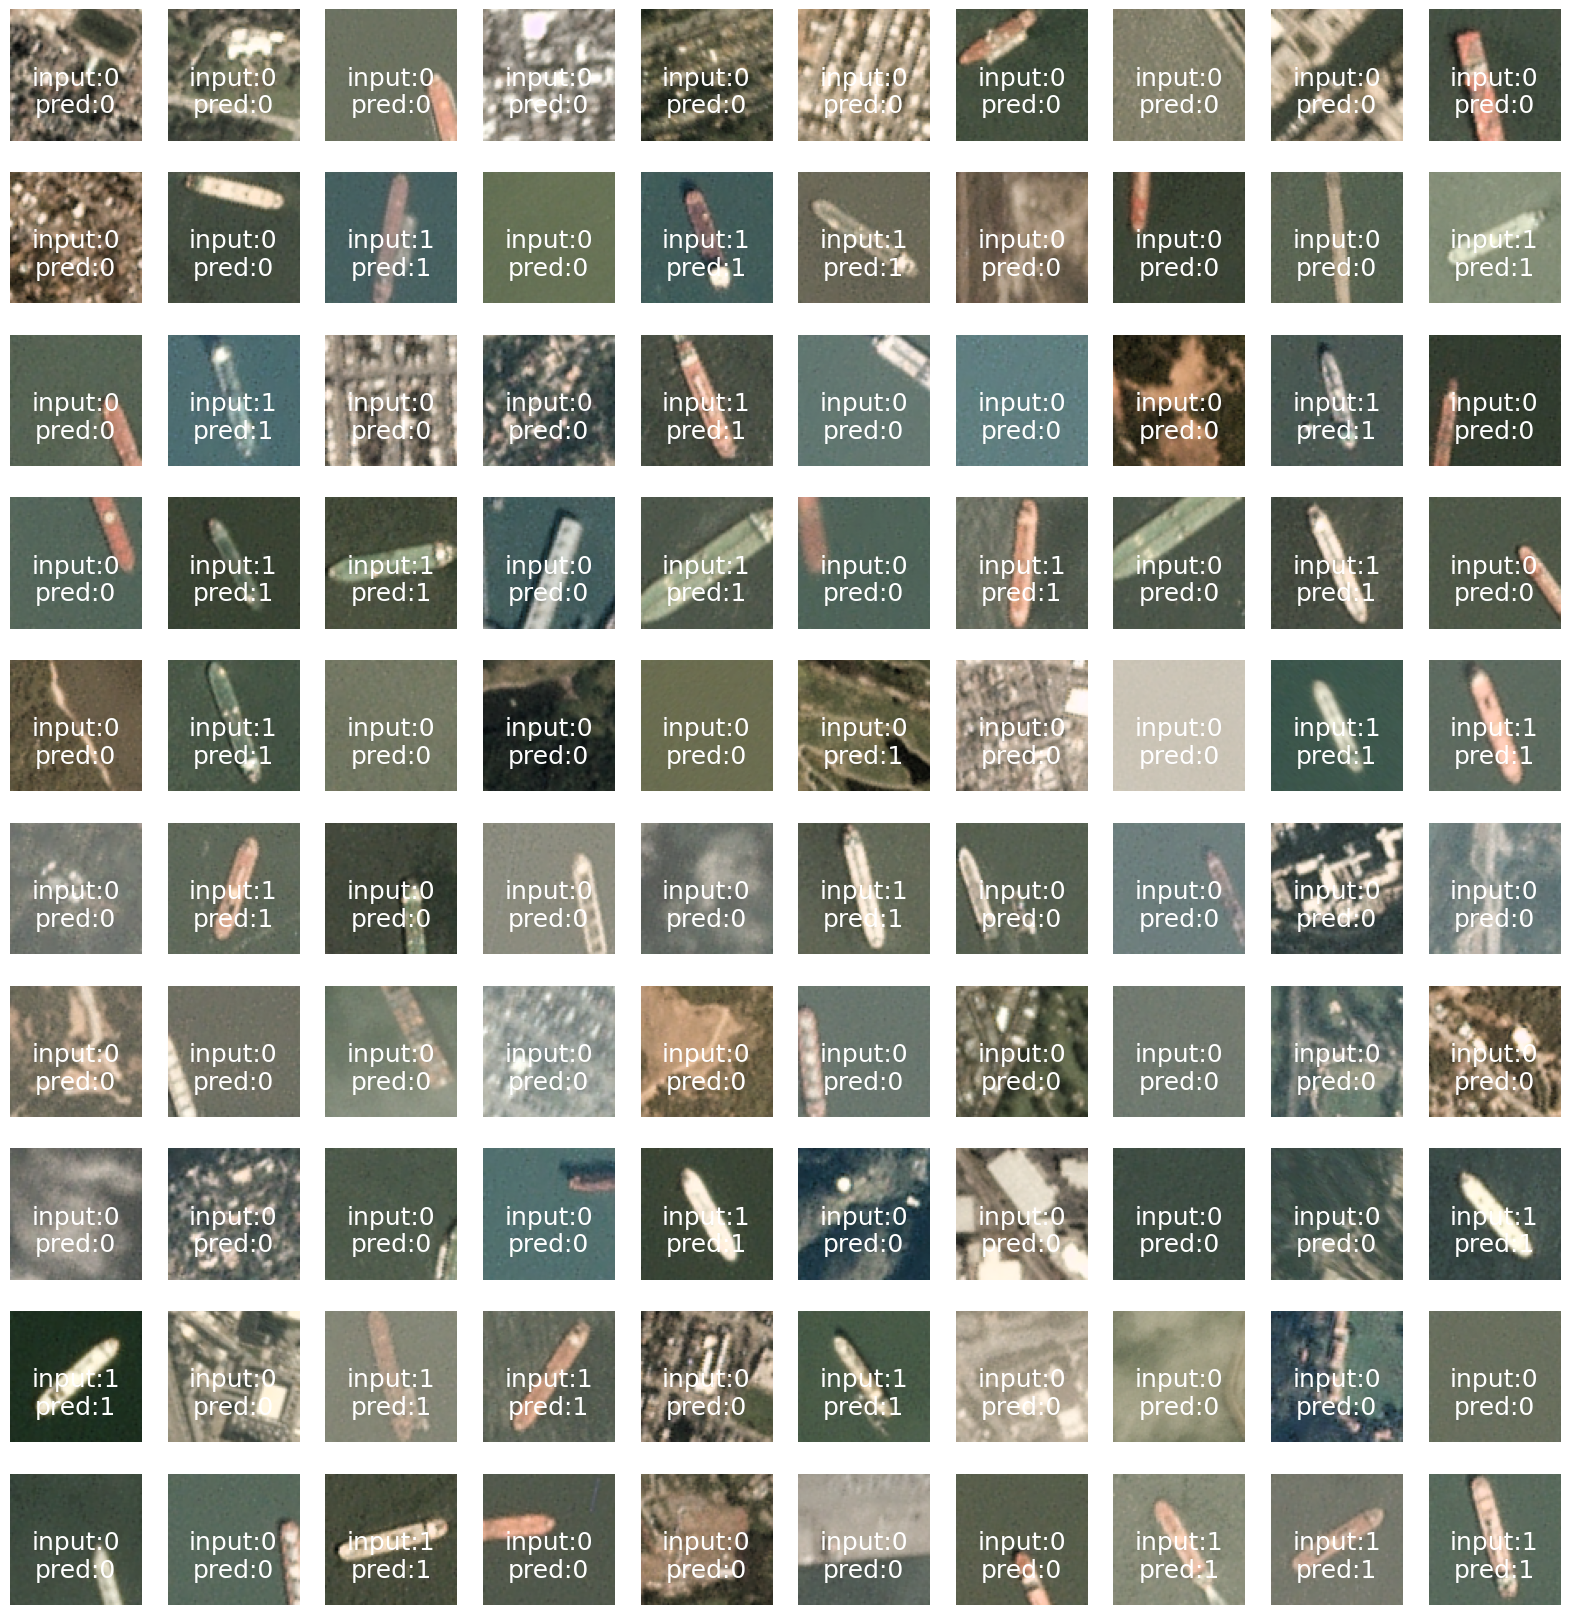

In [36]:
fig=plt.figure(figsize=(20, 20))

random.randint(0,len(data_test))

data_t_test=data_test.transpose(0,2,3,1)
# show each channel
for i in range(0,100):
    fig.add_subplot(10, 10, i+1)
    fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=.2, hspace=.2)
    plt.imshow(data_t_test[i,:,:,:])
    plt.title('input:'+str(labels_test.argmax(axis = 1)[i])+'\npred:'+str(prediction[i]), fontsize=18, y=.15,color='w')
    plt.axis('off')
plt.show()

The plot above gives us a cool look into how our model predicted some individual images. For the most part, this model did great! 

# Conclusion

This project successfully demonstrates the efficacy of a fully convolutional neural network (FCNN) for the automated detection of ships in satellite imagery. The developed model achieved an accuracy of 98% with very quick model training time. 

The architecture's fully convolutional nature proved advantageous, enabling efficient processing of variable-sized images and avoiding the computationally expensive sliding window approach often used in object detection tasks. 
Furthermore, the model's robustness to variations in image resolution, ground variation, and ship types suggests its practical applicability in real-world scenarios. This work contributes a valuable tool for maritime surveillance, port management, and traffic monitoring, offering a significant advancement over traditional methods in terms of speed, accuracy, and scalability. 


Future research will focus on applying this method to the scenes dataset. While I tried to make a selective search model for the scenes, this proved to be filled with errors and took alot more time than I anticipated. Definitely something I will do in the future. The success of this FCNN approach highlights the potential of deep learning techniques for automated analysis of high-resolution satellite imagery and paves the way for similar applications across various object detection domains.